In [1]:
using Plots, LinearAlgebra, Statistics, DataFrames, CSV, NLsolve, Memoize, MLJBase, Pkg, MLJModels, ScikitLearn, Flux, Zygote, Statistics, StatsBase, PyCall, Dates, MLJParticleSwarmOptimization, StatisticalMeasures, MLJTuning, Distributions, MethodChains, SIRUS

In [2]:
include("../utils.jl")

evaluate_trading_strat_sbc (generic function with 1 method)

In [3]:
train_tickers = ["AAPL", "MSFT", "NVDA", "ORCL", "AMZN", "GOOG", "INTC", "META", "TSLA"]
market_tickers = ["^GSPC", "^IXIC", "^VIX", "^RUT", "^DJI"]
start_date = "2000-01-01"
cut_off = "2022-01-01"
window = 14

14

In [4]:
# make_NPMM_data(train_datas[1], 14)
train_datas, test_datas = make_train_test_data(train_tickers, market_tickers, start_date, cut_off)
train_NPMM_labeled_merged = concat_training_datas(train_datas, window)
sort!(train_NPMM_labeled_merged, :Date) 
full_train_X_df = DataFrames.select(train_NPMM_labeled_merged, Not([:Date, :target]))
full_train_X = (full_train_X_df |> Matrix)
full_train_Y = train_NPMM_labeled_merged[:, :target] |> Vector;

In [5]:
EvoTreeClassifier = @load EvoTreeClassifier pkg="EvoTrees"

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\bhatn\.julia\packages\MLJModels\L1gIK\src\loading.jl:159


import EvoTrees

 ✔

EvoTrees.EvoTreeClassifier

In [6]:
evotree = EvoTreeClassifier()
r1 = (MLJTuning.range(evotree, :max_depth, values = 3:7))
r2 = (MLJTuning.range(evotree, :colsample, lower=0.0, upper=1.0), Uniform)
r3 = (range(evotree, :eta, lower = 0.0, upper = 1.0), Uniform)
r4 = (range(evotree, :nrounds, values = 10:30))
r5 = (range(evotree, :L2, lower = 0.0, upper = 10.0), Uniform)
r6 = (range(evotree, :lambda, lower = 0.0, upper = 10.0), Uniform)
r7 = (range(evotree, :gamma, lower = 0.0, upper = 10.0), Uniform)
r8 = (range(evotree, :min_weight, values = 1:5))
r9 = (range(evotree, :rowsample, lower=0.0, upper=1.0), Uniform)
r10 = (range(evotree, :nbins, values = 2:255))
r11 = (range(evotree, :tree_type, values = ["binary", "oblivious"]))
r12 = (range(evotree, :alpha, lower = 0.0, upper = 1.0), Uniform)
# r12 = (range(evotree, :loss, values = [:logistic]))
# r11 = (range(evotree, :scitype_check_level, values = 0))
self_tuning_evotree = MLJTuning.TunedModel(
    model = evotree,
    resampling = TimeSeriesCV(nfolds=5),
    tuning = AdaptiveParticleSwarm(n_particles=3),#Grid(resolution=10, shuffle=true, rng=1234),
    range = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12],
    # measure = (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y),
    measure = [MLJBase.BrierLoss(), (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y)],
    acceleration = CPUThreads(),
    n = 50,
    # scitype_check_level=0
)
mach = machine(self_tuning_evotree, full_train_X, full_train_Y .|> Int64)
MLJBase.fit!(mach,  verbosity=0)
# test_X, test_Y = make_NPMM_data(test_datas[1], window) |> make_matrices
# StatisticalMeasures.accuracy(mode.(MLJBase.predict(mach, test_X)), test_Y .|> Int64)
# evaluate_trading_strat(mach, test_datas[1], .5, :)
report(mach)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJTuning.ProbabilisticTunedModel` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}},

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

(best_model = EvoTrees.EvoTreeClassifier{EvoTrees.MLogLoss}
 - nrounds: 30
 - L2: 2.8651930775935543
 - lambda: 0.1307136953636473
 - gamma: 3.7987423356835484
 - eta: 0.3330265295356461
 - max_depth: 6
 - min_weight: 1.0
 - rowsample: 0.8036630200190199
 - colsample: 0.6857785192565716
 - nbins: 252
 - alpha: 0.5772882052829352
 - tree_type: oblivious
 - rng: Random.MersenneTwister(123, (0, 192390, 191388, 264))
,
 best_history_entry = (model = EvoTrees.EvoTreeClassifier{EvoTrees.MLogLoss}
 - nrounds: 30
 - L2: 2.8651930775935543
 - lambda: 0.1307136953636473
 - gamma: 3.7987423356835484
 - eta: 0.3330265295356461
 - max_depth: 6
 - min_weight: 1.0
 - rowsample: 0.8036630200190199
 - colsample: 0.6857785192565716
 - nbins: 252
 - alpha: 0.5772882052829352
 - tree_type: oblivious
 - rng: Random.MersenneTwister(123, (0, 192390, 191388, 264))
,
                       measure = Any[BrierLoss(), var"#41#42"()],
                       measurement = AbstractFloat[0.123273015f0, 0.92980392156

In [24]:
eval_dicts = [Dict(evaluate_trading_strat(mach, test_data, .8, :)...) for test_data in test_datas]
alltrades = reduce(vcat, [eval_dict[:trade_vals] for eval_dict in eval_dicts])
rr = [eval_dict[:return_rate] for eval_dict in eval_dicts]
arr = [eval_dict[:algo_return_rate] for eval_dict in eval_dicts]
mean_return_rate = mean(rr)
std_return_rate = std(rr)
mean_algo_return_rate = mean(arr)
std_algo_return_rate = std(arr)
[
:win_rate => mean(alltrades .> 0),
:mean_val => mean(alltrades),
:std_val => std(alltrades),
:mean_win => mean(alltrades[alltrades .> 0]),
:mean_loss => mean(alltrades[alltrades .< 0]),
:mean_algo_return_rate => mean_algo_return_rate,
:std_algo_return_rate => std_algo_return_rate,
:mean_return_rate => mean_return_rate,
:std_return_rate => std_return_rate,
]

9-element Vector{Pair{Symbol, Float64}}:
              :win_rate => 0.61328125
              :mean_val => -1.209777221083641
               :std_val => 9.875776410662917
              :mean_win => 3.3908209466630486
             :mean_loss => -8.548851342370668
 :mean_algo_return_rate => -0.3048270307605003
  :std_algo_return_rate => 0.14674169316108418
      :mean_return_rate => -0.4322088120199387
       :std_return_rate => 0.19574630343195018

In [25]:
[(ticker, evaluate_trading_strat(mach, test_data, .8, :)[1:8]) for (test_data, ticker) in zip(test_datas, train_tickers)]

9-element Vector{Tuple{String, Vector{Pair{Symbol, Any}}}}:
 ("AAPL", [:win_rate => 0.6481481481481481, :mean_val => -0.851111235441985, :std_val => 5.062964046364365, :mean_win => 2.170285906110491, :mean_loss => -6.41684281198602, :algo_return => -45.96000671386719, :algo_return_rate => -0.2525136426623046, :asset_return => -52.08000183105469])
 ("MSFT", [:win_rate => 0.6842105263157895, :mean_val => -0.9931584408408717, :std_val => 10.352925721497876, :mean_win => 4.363589164538261, :mean_loss => -12.599444919162327, :algo_return => -56.61003112792969, :algo_return_rate => -0.1691113700610297, :asset_return => -94.92999267578125])
 ("NVDA", [:win_rate => 0.7377049180327869, :mean_val => -1.360656988425333, :std_val => 15.591242798762234, :mean_win => 4.478220791286892, :mean_loss => -17.782500743865967, :algo_return => -83.00007629394531, :algo_return_rate => -0.27555552155820096, :asset_return => -155.0699920654297])
 ("ORCL", [:win_rate => 0.6206896551724138, :mean_val => -0.24155

In [42]:
model = StableRulesClassifier(n_trees = 1_000, lambda = 2)
mach_sbc = machine(model, full_train_X_df, full_train_Y)
# MLJBase.fit!(mach_sbc, verbosity=0)
perf_eval = MLJBase.evaluate!(mach_sbc, resampling=TimeSeriesCV(nfolds=5), measure = (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y), verbosity = 0)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc SIRUS.StableRulesClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Count}}}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}}}, AbstractVector{<:Finite}}
└ @ MLJBase C:\Us

PerformanceEvaluation object with these fields:
  model, measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows, resampling, repeats
Extract:
┌─────────────────┬───────────┬─────────────┬─────────┬─────────────────────────
│ measure         │ operation │ measurement │ 1.96*SE │ per_fold               ⋯
├─────────────────┼───────────┼─────────────┼─────────┼─────────────────────────
│ var"#107#108"() │ predict   │ 0.81        │ 0.058   │ [0.806, 0.846, 0.888,  ⋯
└─────────────────┴───────────┴─────────────┴─────────┴─────────────────────────
                                                                1 column omitted


In [44]:
perf_eval.per_fold

1-element Vector{Vector{Float64}}:
 [0.8058823529411765, 0.846078431372549, 0.888235294117647, 0.7705882352941177, 0.7392156862745098]

In [43]:
mach_sbc.fitresult

StableRules model with 6 rules:
 if X[i, :volatility_kcp] < 0.80790466 then 0.002 else 0.012 +
 if X[i, :momentum_wr] < -29.655165 then 0.003 else 0.016 +
 if X[i, :momentum_stoch] < 70.34483 then 0.003 else 0.017 +
 if X[i, :volatility_kcli] < 1.0 then 0.119 else 0.006 +
 if X[i, :volatility_bbp] < 0.6683319 then 0.005 else 0.02 +
 if X[i, :volatility_kchi] < 1.0 then 0.007 else 0.032
and 2 classes: Real[0, 1]. 
Note: showing only the probability for class 1 since class 0 has probability 1 - p.


In [45]:
mean(predict_mode(mach_sbc, full_train_X_df) .== (full_train_Y .|> Int64))

0.7700098007187194

In [49]:
eval_dicts = [Dict(evaluate_trading_strat_sbc(mach_sbc, test_data, .8, :)...) for test_data in test_datas]
alltrades = reduce(vcat, [eval_dict[:trade_vals] for eval_dict in eval_dicts])
rr = [eval_dict[:return_rate] for eval_dict in eval_dicts]
arr = [eval_dict[:algo_return_rate] for eval_dict in eval_dicts]
mean_return_rate = mean(rr)
std_return_rate = std(rr)
mean_algo_return_rate = mean(arr)
std_algo_return_rate = std(arr)
[
:win_rate => mean(alltrades .> 0),
:mean_val => mean(alltrades),
:std_val => std(alltrades),
:mean_win => mean(alltrades[alltrades .> 0]),
:mean_loss => mean( alltrades[alltrades .< 0]),
:mean_algo_return_rate => mean_algo_return_rate,
:std_algo_return_rate => std_algo_return_rate,
:mean_return_rate => mean_return_rate,
:std_return_rate => std_return_rate,
]

9-element Vector{Pair{Symbol, Float64}}:
              :win_rate => 0.5665024630541872
              :mean_val => -3.52956080319259
               :std_val => 19.816812690908698
              :mean_win => 4.3741250411323875
             :mean_loss => -13.858241167935459
 :mean_algo_return_rate => -0.3006657095165567
  :std_algo_return_rate => 0.17293470708470524
      :mean_return_rate => -0.4322088120199387
       :std_return_rate => 0.19574630343195018

In [38]:
report(mach).best_history_entry.per_fold

2-element Vector{Vector}:
 Float32[0.13371685, 0.14851366, 0.107864656, 0.11215441, 0.12601388]
 Any[0.9254901960784314, 0.9186274509803921, 0.9382352941176471, 0.9392156862745098, 0.9284313725490196]

In [39]:
test_X, test_Y = make_matrices(concat_training_datas(test_datas, window))
mean(predict_mode(mach, test_X) .== (test_Y .|> Int64))

0.9836601307189542

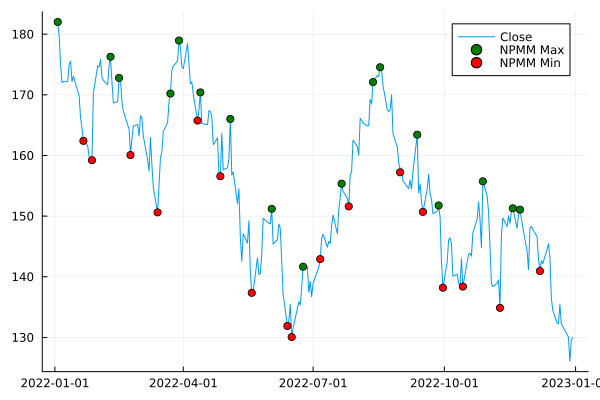

In [40]:
targets = NPMM(test_datas[1], 14)
plot(test_datas[1].Date, test_datas[1].Close, label="Close")
scatter!(test_datas[1].Date[targets .== 1], test_datas[1].Close[targets .== 1], label="NPMM Max", color = :green)
scatter!(test_datas[1].Date[targets .== 0], test_datas[1].Close[targets .== 0], label="NPMM Min", color = :red)

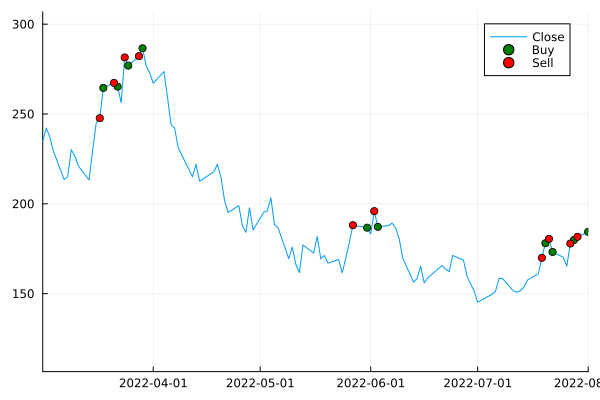

In [41]:
i = 3
buys, sells = zip(eval_dicts[i][:trades]...) .|> collect
plot(test_datas[i].Date, test_datas[i].Close, label="Close")
scatter!(test_datas[i].Date[buys], test_datas[i].Close[buys], label="Buy", color=:green)
scatter!(test_datas[i].Date[sells], test_datas[i].Close[sells], label="Sell", color=:red)
plot!(xlim = (Date(2022, 3, 1), Date(2022, 8, 1)))